# Trabájo Practico 2 - Métodos Computacionales

### Camila Cauzzo, Catalina Dolhare

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import time

In [15]:
def abrirImagenesEscaladas( carpeta, escala=32 ):
    # abre todas las imagenes de la carpeta, y las escala de tal forma que midan (escala x escala)px
    # devuelve las imagenes aplanadas -> vectores de tamano escala^2 con valores entre 0 y 1
    imagenes = []

    for dirpath, dirnames, filenames in os.walk(carpeta):
        for file in filenames:
            img = Image.open( os.path.join(carpeta, file) )
            img = img.resize((escala, escala))
            img.convert('1')
            img = np.asarray(img)
            if len(img.shape)==3:
                img = img[:,:,0].reshape((escala**2 )) / 255
            else:
                img = img.reshape((escala**2 )) / 255
            
            imagenes.append( img )

    return imagenes

In [16]:
def balancear_datos(imagenes1, imagenes2):
    cantidad_imagenes = min(len(imagenes1), len(imagenes2))
    imagenes1 = imagenes1[:cantidad_imagenes]
    imagenes2 = imagenes2[:cantidad_imagenes]

    imagenes = imagenes1 + imagenes2

    return imagenes

### Ejercicio 1

Calcular las derivadas parciales de la funci ́on L con respecto a w y b 

In [17]:
def L_w(i, w, b, d):
    t0 = np.tanh(np.dot(w, i) + b)
    return (1 - t0**2) * (((1 + t0) / 2) - d) * i

In [18]:
def L_b(i, w, b, d):
    t0 = np.tanh(np.dot(w, i) + b)
    return (1 - t0**2) * (((1 + t0) / 2) - d)

In [19]:
def f(i, w, b):
    tan = np.tanh(np.dot(w, i) + b)
    return (tan + 1) / 2

In [20]:
def dL_dw(w, b, imagenes, diagnosticos):
    gradiente = np.zeros_like(w)
    for i, imagen in enumerate(imagenes):
        gradiente += L_w(imagen, w, b, diagnosticos[i])
    return gradiente / len(imagenes)

In [21]:
def dL_db(w, b, imagenes, diagnosticos):
    gradiente = 0
    for i, imagen in enumerate(imagenes):
        gradiente += L_b(imagen, w, b, diagnosticos[i])
    return gradiente / len(imagenes)

In [22]:
def func_L(w, b, imagenes, diagnosticos):
    error = 0
    for i, imagen in enumerate(imagenes):
        prediccion = f(imagen, w, b)
        error += (prediccion - diagnosticos[i])**2
    return error / len(imagenes)

### Ejercicio 2

Implementar el método de descenso por gradiente y optimizar los parámetros de la función f para
el conjunto de datos de entrenamiento

In [23]:
def gradiente_descendiente(imagenes1, imagenes2):
    imagenes_normal = abrirImagenesEscaladas(imagenes1)
    diagnosticos_normal = [0] * len(imagenes_normal)

    imagenes_neumonia = abrirImagenesEscaladas(imagenes2)
    diagnosticos_neumonia = [1] * len(imagenes_neumonia)

    imagenes = balancear_datos(imagenes_normal, imagenes_neumonia)
    diagnosticos = diagnosticos_normal + diagnosticos_neumonia

    w_t = np.zeros(imagenes[0].shape[0])
    b_t = np.random.rand(1)

    MAX_ITER = 1000
    TOLERANCIA = 1e-8
    alpha = 0.01

    iteracion = 0

    while iteracion <= MAX_ITER:
        print("Iteración: ", iteracion, "- Mínimo alcanzado hasta el momento: ", func_L(w_t, b_t, imagenes, diagnosticos))

        gradient_dw = dL_dw(w_t, b_t, imagenes, diagnosticos)
        gradient_db = dL_db(w_t, b_t, imagenes, diagnosticos)

        w_t_mas_1 = w_t - alpha * gradient_dw
        b_t_mas_1 = b_t - alpha * gradient_db

        dif = func_L(w_t_mas_1, b_t_mas_1, imagenes, diagnosticos) - func_L(w_t, b_t, imagenes, diagnosticos)

        if abs(dif) < TOLERANCIA:
            break

        w_t = w_t_mas_1
        b_t = b_t_mas_1

        iteracion += 1
    
    return w_t, b_t, imagenes, diagnosticos

In [24]:
w_opt, b_opt, imagenes, diagnosticos, errores = gradiente_descendiente("chest_xray/train/NORMAL", "chest_xray/train/PNEUMONIA", 0.01, 32)
print("El mínimo local ocurre en w = ", w_opt, "b = ", b_opt, " y L vale: ", func_L(w_opt, b_opt, imagenes, diagnosticos))

TypeError: gradiente_descendiente() takes 2 positional arguments but 4 were given

### Ejercicio 3

Calcular el error cuadrático durante la optimización para el conjunto de entrenamiento y para
el conjunto de testing. Generar las visualizaciones correspondientes.

In [25]:
def error_cuadratico_medio(imagenes, diagnostico, w, b):
    error_total = 0
    for i in range(len(imagenes)):
        error = (f(imagenes[i], w, b) - diagnostico[i])**2
        error_total += error

    return error_total/len(imagenes)

In [26]:
def predecir(imagenes, w, b):
    predicciones = []
    for imagen in imagenes:
        prediccion = f(imagen, w, b)
        predicciones.append(prediccion)
    return predicciones

In [27]:
def error_prediccion(predicciones, diagnosticos):
    error = 0
    for i in range(len(predicciones)):
        error += (predicciones[i] - diagnosticos[i])**2
    return error / len(predicciones)

In [28]:
def gradiente_descendiente_con_errores(imagenes1_train, imagenes2_train, imagenes1_test, imagenes2_test):
    imagenes_normal_train = abrirImagenesEscaladas(imagenes1_train)
    diagnosticos_normal_train = [0] * len(imagenes_normal_train)

    imagenes_neumonia_train = abrirImagenesEscaladas(imagenes2_train)
    diagnosticos_neumonia_train = [1] * len(imagenes_neumonia_train)

    imagenes_train = balancear_datos(imagenes_normal_train, imagenes_neumonia_train)
    diagnosticos_train = diagnosticos_normal_train + diagnosticos_neumonia_train

    imagenes_normal_test = abrirImagenesEscaladas(imagenes1_test)
    diagnosticos_normal_test = [0] * len(imagenes_normal_test)

    imagenes_neumonia_test = abrirImagenesEscaladas(imagenes2_test)
    diagnosticos_neumonia_test = [1] * len(imagenes_neumonia_test)

    imagenes_test = balancear_datos(imagenes_normal_test, imagenes_neumonia_test)
    diagnosticos_test = diagnosticos_normal_test + diagnosticos_neumonia_test

    w_t = np.zeros(imagenes_train[0].shape[0])
    b_t = np.random.rand(1)

    MAX_ITER = 1000
    TOLERANCIA = 1e-8
    alpha = 0.01

    iteracion = 0
    loss = []
    errores = []
    predicciones = []
    errores_prediccion = []

    while iteracion <= MAX_ITER:
        print("Iteración: ", iteracion, "- Mínimo alcanzado hasta el momento: ", func_L(w_t, b_t, imagenes_train, diagnosticos_train))

        loss.append(func_L(w_t, b_t, imagenes_train, diagnosticos_train))

        error = error_cuadratico_medio(imagenes_train, diagnosticos_train, w_t, b_t)
        errores.append(error)

        prediccion = predecir(imagenes_test, w_t, b_t)
        predicciones.append(prediccion)
        error_pred = error_prediccion(prediccion, diagnosticos_test)
        errores_prediccion.append(error_pred)

        gradient_dw = dL_dw(w_t, b_t, imagenes_train, diagnosticos_train)
        gradient_db = dL_db(w_t, b_t, imagenes_train, diagnosticos_train)

        w_t_mas_1 = w_t - alpha * gradient_dw
        b_t_mas_1 = b_t - alpha * gradient_db

        dif = func_L(w_t_mas_1, b_t_mas_1, imagenes_train, diagnosticos_train) - func_L(w_t, b_t, imagenes_train, diagnosticos_train)

        if abs(dif) < TOLERANCIA:
            break

        w_t = w_t_mas_1
        b_t = b_t_mas_1

        iteracion += 1
    print("El mínimo local ocurre en w = ", w_t, "b = ", b_t, " y L vale: ", func_L(w_t, b_t, imagenes_train, diagnosticos_train))
    return w_t, b_t, loss, errores, predicciones, errores_prediccion

In [29]:
w_opt, b_opt, loss, errores, predicciones, error_pred = gradiente_descendiente_con_errores("chest_xray/train/NORMAL", "chest_xray/train/PNEUMONIA", "chest_xray/test/NORMAL", "chest_xray/test/PNEUMONIA")

Iteración:  0 - Mínimo alcanzado hasta el momento:  [0.30605498]
Iteración:  1 - Mínimo alcanzado hasta el momento:  [0.25277922]
Iteración:  2 - Mínimo alcanzado hasta el momento:  [0.25052581]
Iteración:  3 - Mínimo alcanzado hasta el momento:  [0.24834366]
Iteración:  4 - Mínimo alcanzado hasta el momento:  [0.24620321]
Iteración:  5 - Mínimo alcanzado hasta el momento:  [0.24409969]
Iteración:  6 - Mínimo alcanzado hasta el momento:  [0.24203213]
Iteración:  7 - Mínimo alcanzado hasta el momento:  [0.24000019]
Iteración:  8 - Mínimo alcanzado hasta el momento:  [0.23800358]
Iteración:  9 - Mínimo alcanzado hasta el momento:  [0.23604201]
Iteración:  10 - Mínimo alcanzado hasta el momento:  [0.23411517]
Iteración:  11 - Mínimo alcanzado hasta el momento:  [0.2322227]
Iteración:  12 - Mínimo alcanzado hasta el momento:  [0.23036425]
Iteración:  13 - Mínimo alcanzado hasta el momento:  [0.22853941]
Iteración:  14 - Mínimo alcanzado hasta el momento:  [0.22674776]
Iteración:  15 - Míni

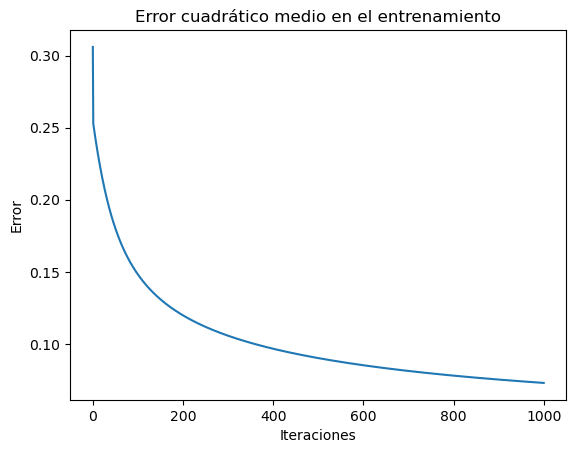

In [38]:
plt.plot(errores)
plt.xlabel("Iteraciones")
plt.ylabel("Error")
plt.title("Error cuadrático medio en el entrenamiento")
plt.show()

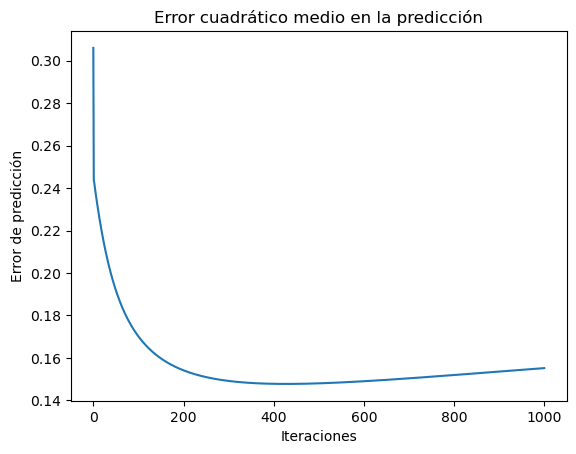

In [31]:
plt.plot(error_pred)
plt.xlabel("Iteraciones")
plt.ylabel("Error de predicción")
plt.title("Error cuadrático medio en la predicción")
plt.show()

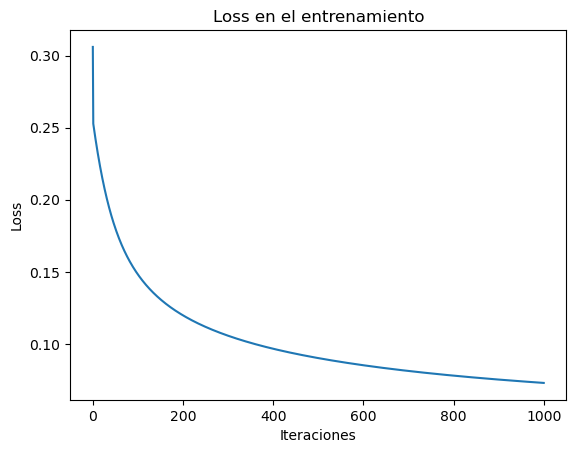

In [32]:
plt.plot(loss)
plt.xlabel("Iteraciones")
plt.ylabel("Loss")
plt.title("Loss en el entrenamiento")
plt.show()

In [33]:
error_pred_optimo = error_pred[-1]
print("El error de predicción óptimo es: ", error_pred_optimo)

El error de predicción óptimo es:  [0.15514522]


### Ejercicio 4

Analizar el impacto del parámetro α en la convergencia del método. Tomar un rango
de 5 valores posibles y analizar la convergencia para el conjunto de testing para los distintos valores de α.

El parametro alpha es muy importante a la hora de encontrar el minimo. Este determina cuanto vamos a movernos en dirección al gradiente. Si este es muy chico, encontrar el minimo va a tardar muchos iteración y, dependiendo de el valor maximo, es posible que no se encuentre. Si se elige un valor muy grande, es posible que nos pasemos del valor minimo local.

In [39]:
def gradiente_descendiente_con_errores_alpha(imagenes1_train, imagenes2_train, imagenes1_test, imagenes2_test, alpha):
    imagenes_normal_train = abrirImagenesEscaladas(imagenes1_train)
    diagnosticos_normal_train = [0] * len(imagenes_normal_train)

    imagenes_neumonia_train = abrirImagenesEscaladas(imagenes2_train)
    diagnosticos_neumonia_train = [1] * len(imagenes_neumonia_train)

    imagenes_train = balancear_datos(imagenes_normal_train, imagenes_neumonia_train)
    diagnosticos_train = diagnosticos_normal_train + diagnosticos_neumonia_train

    imagenes_normal_test = abrirImagenesEscaladas(imagenes1_test)
    diagnosticos_normal_test = [0] * len(imagenes_normal_test)

    imagenes_neumonia_test = abrirImagenesEscaladas(imagenes2_test)
    diagnosticos_neumonia_test = [1] * len(imagenes_neumonia_test)

    imagenes_test = balancear_datos(imagenes_normal_test, imagenes_neumonia_test)
    diagnosticos_test = diagnosticos_normal_test + diagnosticos_neumonia_test

    w_t = np.zeros(imagenes_test[0].shape[0])
    b_t = np.random.rand(1)

    MAX_ITER = 1000
    TOLERANCIA = 1e-8

    iteracion = 0
    loss = []
    errores = []
    predicciones = []
    errores_prediccion = []

    while iteracion <= MAX_ITER:
        loss.append(func_L(w_t, b_t, imagenes_train, diagnosticos_train))

        error = error_cuadratico_medio(imagenes_train, diagnosticos_train, w_t, b_t)
        errores.append(error)

        prediccion = predecir(imagenes_test, w_t, b_t)
        predicciones.append(prediccion)
        error_pred = error_prediccion(prediccion, diagnosticos_test)
        errores_prediccion.append(error_pred)

        gradient_dw = dL_dw(w_t, b_t, imagenes_train, diagnosticos_train)
        gradient_db = dL_db(w_t, b_t, imagenes_train, diagnosticos_train)

        w_t_mas_1 = w_t - alpha * gradient_dw
        b_t_mas_1 = b_t - alpha * gradient_db

        dif = func_L(w_t_mas_1, b_t_mas_1, imagenes_train, diagnosticos_train) - func_L(w_t, b_t, imagenes_train, diagnosticos_train)

        if abs(dif) < TOLERANCIA:
            break

        w_t = w_t_mas_1
        b_t = b_t_mas_1

        iteracion += 1
    print("El mínimo local ocurre en w = ", w_t, "b = ", b_t, " y L vale: ", func_L(w_t, b_t, imagenes_train, diagnosticos_train))
    return w_t, b_t, loss, errores, predicciones, errores_prediccion, iteracion

In [41]:
alpha = [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1]
iteraciones = []
losses = []
errores_por_alpha = []
errores_predicciones_por_alpha = []
for a in alpha:
    w_opt, b_opt, loss, errores, predicciones, errores_prediccion, iteracion = gradiente_descendiente_con_errores_alpha("chest_xray/train/NORMAL", "chest_xray/train/PNEUMONIA", "chest_xray/test/NORMAL", "chest_xray/test/PNEUMONIA", a)
    print("Alpha: ", a, "Iteraciones:", iteracion)
    iteraciones.append(iteracion)
    losses.append(loss)
    errores_por_alpha.append(errores)
    errores_predicciones_por_alpha.append(errores_prediccion)

El mínimo local ocurre en w =  [-3.36003074e-06 -4.60253320e-06 -5.93725902e-06 ... -5.84657468e-06
 -1.80681107e-06  1.49967269e-07] b =  [0.45492571]  y L vale:  [0.29453703]
Alpha:  1e-07 Iteraciones: 1001
El mínimo local ocurre en w =  [ 1.25864603e-05 -1.23880943e-04 -9.61379798e-04 ... -1.90049664e-03
  6.99468535e-05  1.28194533e-03] b =  [0.23511167]  y L vale:  [0.23127164]
Alpha:  0.0001 Iteraciones: 1001
El mínimo local ocurre en w =  [ 0.00100826  0.00082532 -0.00599101 ... -0.01124283  0.00123087
  0.00967919] b =  [0.88013277]  y L vale:  [0.15055576]
Alpha:  0.001 Iteraciones: 1001
El mínimo local ocurre en w =  [-8.46558545e-05  5.18050635e-03 -3.06441212e-02 ... -3.23541850e-02
 -6.75969325e-04  3.50040102e-02] b =  [0.21135563]  y L vale:  [0.07238079]
Alpha:  0.01 Iteraciones: 1001
El mínimo local ocurre en w =  [ 0.01036363  0.01982961 -0.05628399 ... -0.06836097  0.0020539
  0.073952  ] b =  [0.05267773]  y L vale:  [0.09061425]
Alpha:  0.1 Iteraciones: 1001
El mín

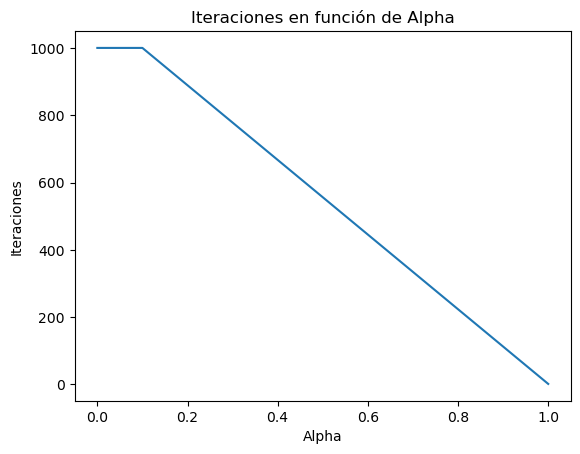

In [42]:
plt.plot(alpha, iteraciones)
plt.xlabel("Alpha")
plt.ylabel("Iteraciones")
plt.title("Iteraciones en función de Alpha")
plt.show()

In [69]:
print(iteraciones[0])
print(errores_por_alpha[0])

1001
[array([0.25099615]), array([0.25099611]), array([0.25099608]), array([0.25099604]), array([0.250996]), array([0.25099596]), array([0.25099592]), array([0.25099588]), array([0.25099584]), array([0.2509958]), array([0.25099576]), array([0.25099572]), array([0.25099569]), array([0.25099565]), array([0.25099561]), array([0.25099557]), array([0.25099553]), array([0.25099549]), array([0.25099545]), array([0.25099541]), array([0.25099537]), array([0.25099534]), array([0.2509953]), array([0.25099526]), array([0.25099522]), array([0.25099518]), array([0.25099514]), array([0.2509951]), array([0.25099506]), array([0.25099502]), array([0.25099498]), array([0.25099495]), array([0.25099491]), array([0.25099487]), array([0.25099483]), array([0.25099479]), array([0.25099475]), array([0.25099471]), array([0.25099467]), array([0.25099463]), array([0.25099459]), array([0.25099456]), array([0.25099452]), array([0.25099448]), array([0.25099444]), array([0.2509944]), array([0.25099436]), array([0.2509

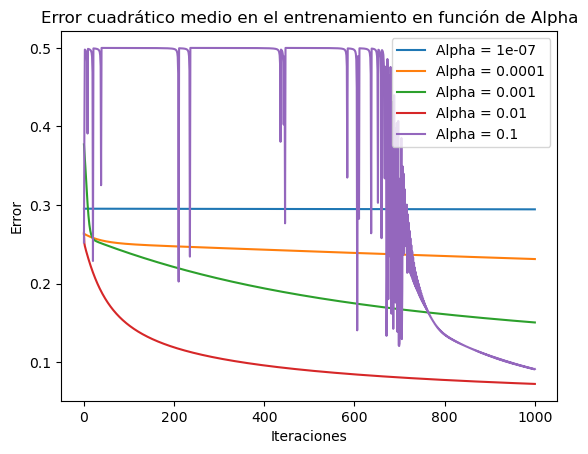

In [43]:
plt.plot(range(iteraciones[0]), errores_por_alpha[0], label="Alpha = " + str(alpha[0]))
plt.plot(range(iteraciones[1]), errores_por_alpha[1], label="Alpha = " + str(alpha[1]))
plt.plot(range(iteraciones[2]), errores_por_alpha[2], label="Alpha = " + str(alpha[2]))
plt.plot(range(iteraciones[3]), errores_por_alpha[3], label="Alpha = " + str(alpha[3]))
plt.plot(range(iteraciones[4]), errores_por_alpha[4], label="Alpha = " + str(alpha[4]))

plt.xlabel("Iteraciones")
plt.ylabel("Error")
plt.title("Error cuadrático medio en el entrenamiento en función de Alpha")
plt.legend()
plt.show()


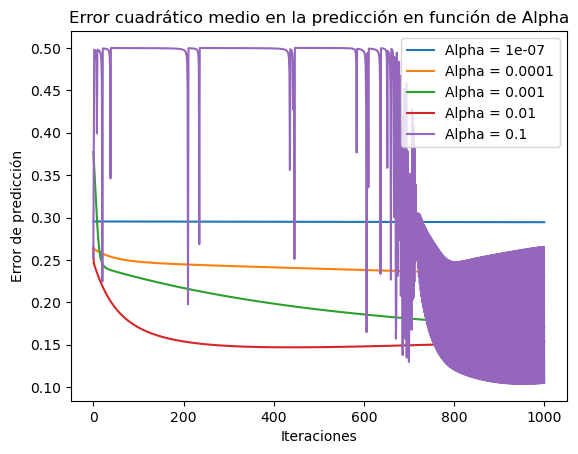

In [44]:
plt.plot(range(iteraciones[0]), errores_predicciones_por_alpha[0], label="Alpha = " + str(alpha[0]))
plt.plot(range(iteraciones[1]), errores_predicciones_por_alpha[1], label="Alpha = " + str(alpha[1]))
plt.plot(range(iteraciones[2]), errores_predicciones_por_alpha[2], label="Alpha = " + str(alpha[2]))
plt.plot(range(iteraciones[3]), errores_predicciones_por_alpha[3], label="Alpha = " + str(alpha[3]))
plt.plot(range(iteraciones[4]), errores_predicciones_por_alpha[4], label="Alpha = " + str(alpha[4]))

plt.xlabel("Iteraciones")
plt.ylabel("Error de predicción")
plt.title("Error cuadrático medio en la predicción en función de Alpha")
plt.legend()
plt.show()

### Ejercicio 5

¿Cómo impacta el tamaño del escalado de las imágenes en la efectividad del método? ¿Y en el
tiempo de cómputo?. Realizar los experimentos y gráficos acordes para estudiar estas limitaciones

In [46]:
def gradiente_descendiente_con_errores_escalado(imagenes1_train, imagenes2_train, imagenes1_test, imagenes2_test, escalado):
    imagenes_normal_train = abrirImagenesEscaladas(imagenes1_train, escalado)
    diagnosticos_normal_train = [0] * len(imagenes_normal_train)

    imagenes_neumonia_train = abrirImagenesEscaladas(imagenes2_train, escalado)
    diagnosticos_neumonia_train = [1] * len(imagenes_neumonia_train)

    imagenes_train = balancear_datos(imagenes_normal_train, imagenes_neumonia_train)
    diagnosticos_train = diagnosticos_normal_train + diagnosticos_neumonia_train

    imagenes_normal_test = abrirImagenesEscaladas(imagenes1_test)
    diagnosticos_normal_test = [0] * len(imagenes_normal_test)

    imagenes_neumonia_test = abrirImagenesEscaladas(imagenes2_test)
    diagnosticos_neumonia_test = [1] * len(imagenes_neumonia_test)

    imagenes_test = balancear_datos(imagenes_normal_test, imagenes_neumonia_test)
    diagnosticos_test = diagnosticos_normal_test + diagnosticos_neumonia_test

    print(imagenes_train[0].shape[0])
    w_t = np.zeros(imagenes_train[0].shape[0])
    b_t = np.random.rand(1)

    MAX_ITER = 1000
    TOLERANCIA = 1e-8
    alpha = 0.01

    iteracion = 0
    loss = []
    errores = []
    predicciones = []
    errores_prediccion = []

    while iteracion <= MAX_ITER:
        loss.append(func_L(w_t, b_t, imagenes_train, diagnosticos_train))

        error = error_cuadratico_medio(imagenes_test, diagnosticos_test, w_t, b_t)
        errores.append(error)

        prediccion = predecir(imagenes_test, w_t, b_t)
        predicciones.append(prediccion)
        error_pred = error_prediccion(prediccion, diagnosticos_test)
        errores_prediccion.append(error_pred)

        gradient_dw = dL_dw(w_t, b_t, imagenes_train, diagnosticos_train)
        gradient_db = dL_db(w_t, b_t, imagenes_train, diagnosticos_train)

        w_t_mas_1 = w_t - alpha * gradient_dw
        b_t_mas_1 = b_t - alpha * gradient_db

        dif = func_L(w_t_mas_1, b_t_mas_1, imagenes_train, diagnosticos_train) - func_L(w_t, b_t, imagenes_train, diagnosticos_train)

        if abs(dif) < TOLERANCIA:
            break

        w_t = w_t_mas_1
        b_t = b_t_mas_1

        iteracion += 1
    print("El mínimo local ocurre en w = ", w_t, "b = ", b_t, " y L vale: ", func_L(w_t, b_t, imagenes_test, diagnosticos_test))
    return w_t, b_t, errores, predicciones, errores_prediccion, iteracion

In [47]:
escalado = [16, 32, 64, 128, 256, 512]
errores_por_escalado = []
errores_prediccion_por_escalado = []
iteraciones_por_escalado = []
tiempos_por_escalado = []

for e in escalado:
    tiempo_inicial = time.time()
    w_opt, b_opt, errores, predicciones, errores_prediccion, iteracion = gradiente_descendiente_con_errores_escalado("chest_xray/train/NORMAL", "chest_xray/train/PNEUMONIA", "chest_xray/test/NORMAL", "chest_xray/test/PNEUMONIA",  e)
    tiempo_final = time.time()
    print("Tiempo de ejecución: ", tiempo_final-tiempo_inicial)
    print("Escala: ", e,  "tiempo:", tiempo_final-tiempo_inicial)
    errores_por_escalado.append(errores)
    errores_prediccion_por_escalado.append(errores_prediccion)
    iteraciones_por_escalado.append(iteracion)
    tiempos_por_escalado.append(tiempo_final-tiempo_inicial)

256


ValueError: shapes (256,) and (1024,) not aligned: 256 (dim 0) != 1024 (dim 0)

### Ejercicio 6

Para el valor de α que tenga mejor valor de convergencia, generar la matriz de confusión y analizar
brevemente la efectividad del método.